In [1]:
import os
for dirname, _, filenames in os.walk('data\multi-class-knee-osteoporosis-x-ray-dataset'):
    for filename in filenames:
        os.path.join(dirname, filename)

In [2]:
import tensorflow as tf
print(tf.__version__)


2.10.1


In [3]:
import pandas as pd
import numpy as np
import keras
import warnings
warnings.filterwarnings(action="ignore")
import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
# from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.callbacks import TensorBoard,EarlyStopping

import sklearn.metrics as metrics
from keras.callbacks import LearningRateScheduler
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)

In [4]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4973711264470043440
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5821693952
locality {
  bus_id: 1
  links {
  }
}
incarnation: 753560478868022337
physical_device_desc: "device: 0, name: NVIDIA RTX A2000 8GB Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


In [5]:
# import cv2
# import os

# # Directory where your images are located
# input_directory = '/kaggle/input/osteoporosis-database/Osteoporosis Knee X-ray/osteopenia'
# # Directory where you want to save the modified images
# output_directory = '/kaggle/working/newinput'

# # Create the output directory if it doesn't exist
# if not os.path.exists(output_directory):
#     os.makedirs(output_directory)

# # Loop through the images in the input directory
# for filename in os.listdir(input_directory):
#     if filename.endswith(".jpg"):  # Modify the file extension as needed
#         # Load the image
#         image_path = os.path.join(input_directory, filename)
#         img = cv2.imread(image_path)
        
#         # Zoom the image (resize)
#         zoomed_img = cv2.resize(img, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
        
#         # Flip the image horizontally
#         flipped_img = cv2.flip(zoomed_img, 1)
        
#         # Save the modified image
#         output_path = os.path.join(output_directory, filename)
#         cv2.imwrite(output_path, flipped_img)

# print("Images have been processed and saved to the output directory.")


In [6]:
import os
for dirname, _, filenames in os.walk('/kaggle/working/'):
    for filename in filenames:
        os.path.join(dirname, filename)

In [7]:
import os
import pandas as pd

healthy_dirs = [
    r'OS_Collected_Data\normal',
]

osteopenia_dir = [ r'OS_Collected_Data\Osteopenia']
osteoporosis_dirs = [
    r'OS_Collected_Data\Osteoporosis',
]

filepaths = []
labels = []
dict_lists = [healthy_dirs, osteopenia_dir, osteoporosis_dirs]
class_labels = ['Healthy', 'Osteopenia', 'Osteoporosis']

for i, dir_list in enumerate(dict_lists):
    for j in dir_list:
        flist = os.listdir(j)
        for f in flist:
            fpath = os.path.join(j, f)
            filepaths.append(fpath)
            labels.append(class_labels[i])

Fseries = pd.Series(filepaths, name="filepaths")
Lseries = pd.Series(labels, name="labels")
knee_osteoporosis_data = pd.concat([Fseries, Lseries], axis=1)
knee_osteoporosis_df = pd.DataFrame(knee_osteoporosis_data)
print(knee_osteoporosis_df.head())
print(knee_osteoporosis_df["labels"].value_counts())


                                 filepaths   labels
0    OS_Collected_Data\normal\Normal 1.png  Healthy
1   OS_Collected_Data\normal\Normal 10.png  Healthy
2  OS_Collected_Data\normal\Normal 100.jpg  Healthy
3  OS_Collected_Data\normal\Normal 101.jpg  Healthy
4  OS_Collected_Data\normal\Normal 102.jpg  Healthy
labels
Healthy         289
Osteopenia      234
Osteoporosis    212
Name: count, dtype: int64


In [8]:
knee_osteoporosis_df.shape

(735, 2)

In [9]:
train_set, val_train_images = train_test_split(knee_osteoporosis_df, test_size=0.4, random_state=42)
val_set,test_set  = train_test_split(val_train_images, test_size=0.33, random_state=42)

In [10]:
print(train_set.shape)
print(test_set.shape)
print(val_set.shape)


(441, 2)
(98, 2)
(196, 2)


In [11]:
image_gen = ImageDataGenerator(preprocessing_function= tf.keras.applications.mobilenet_v2.preprocess_input)
train = image_gen.flow_from_dataframe(dataframe= train_set,x_col="filepaths",y_col="labels",
                                      target_size=(244,244),
                                      color_mode='rgb',
                                      class_mode="categorical", #used for Sequential Model
                                      batch_size=4,
                                      shuffle=False            #do not shuffle data
                                     )
test = image_gen.flow_from_dataframe(dataframe= test_set,x_col="filepaths", y_col="labels",
                                     target_size=(244,244),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=4,
                                     shuffle= False
                                    )
val = image_gen.flow_from_dataframe(dataframe= val_set,x_col="filepaths", y_col="labels",
                                    target_size=(244,244),
                                    color_mode= 'rgb',
                                    class_mode="categorical",
                                    batch_size=4,
                                    shuffle=False
                                   )

Found 441 validated image filenames belonging to 3 classes.


Found 98 validated image filenames belonging to 3 classes.
Found 196 validated image filenames belonging to 3 classes.


In [12]:
classes=list(train.class_indices.keys())
print (classes)

['Healthy', 'Osteopenia', 'Osteoporosis']


In [13]:
def show_knee_images(image_gen):
    test_dict = test.class_indices
    classes = list(test_dict.keys())
    images, labels=next(image_gen) # get a sample batch from the generator
    plt.figure(figsize=(20,20))
    length = len(labels)
    if length<25:
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5,5,i+1)
        image=(images[i]+1)/2 #scale images between 0 and 1
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color="green",fontsize=16)
        plt.axis('off')
    plt.show()

In [14]:
train

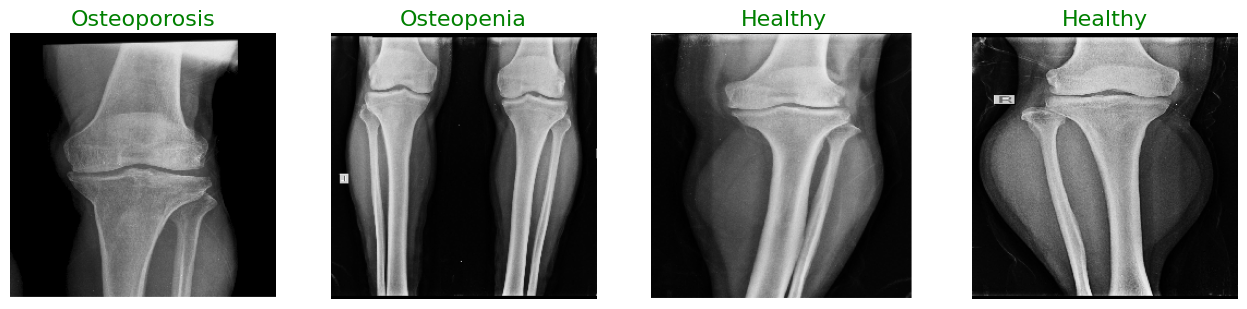

In [15]:
show_knee_images(train)

In [16]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=128, kernel_size=(8, 8), strides=(3, 3), activation='relu', input_shape=(224, 224, 3)),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3, 3)),
    
    keras.layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    
    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    
    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    
    keras.layers.Flatten(),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(3, activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.optimizers.SGD(learning_rate=0.001),
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 73, 73, 128)       24704     
                                                                 
 batch_normalization (BatchN  (None, 73, 73, 128)      512       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 73, 73, 256)       819456    
                                                                 
 batch_normalization_1 (Batc  (None, 73, 73, 256)      1024      
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 256)      0         
 )                                                               
                                                        

In [17]:
history = model.fit(train, epochs=17, validation_data=val, verbose=1)

Epoch 1/17
111/111 [==============================] - 23s 131ms/step - loss: 1.8245 - accuracy: 0.5057 - val_loss: 1.2006 - val_accuracy: 0.4031
Epoch 2/17
111/111 [==============================] - 13s 120ms/step - loss: 1.3938 - accuracy: 0.5941 - val_loss: 0.9047 - val_accuracy: 0.5153
Epoch 3/17
111/111 [==============================] - 14s 124ms/step - loss: 1.1283 - accuracy: 0.6281 - val_loss: 0.9798 - val_accuracy: 0.5510
Epoch 4/17
111/111 [==============================] - 14s 122ms/step - loss: 0.9760 - accuracy: 0.6735 - val_loss: 0.7860 - val_accuracy: 0.6786
Epoch 5/17
111/111 [==============================] - 14s 128ms/step - loss: 0.9287 - accuracy: 0.6780 - val_loss: 0.7050 - val_accuracy: 0.6939
Epoch 6/17
111/111 [==============================] - 15s 131ms/step - loss: 0.8550 - accuracy: 0.6757 - val_loss: 0.7843 - val_accuracy: 0.7143
Epoch 7/17
111/111 [==============================] - 29s 260ms/step - loss: 0.6930 - accuracy: 0.7347 - val_loss: 0.7115 - val_ac

In [18]:
model.evaluate(test, verbose=1)

25/25 [==============================] - 5s 190ms/step - loss: 0.8489 - accuracy: 0.6531


[0.8489296436309814, 0.6530612111091614]

In [19]:
model.save("Osteoporosis_Model.h5")

In [20]:
pred = model.predict(test)
pred = np.argmax(pred, axis=1) #pick class with highest  probability

labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred2 = [labels[k] for k in pred]

25/25 [==============================] - 5s 164ms/step


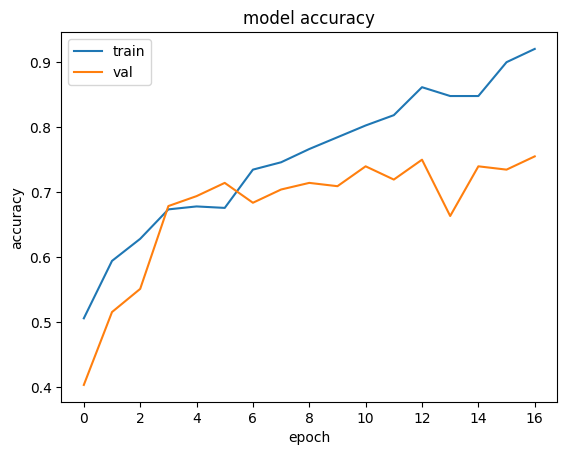

In [21]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

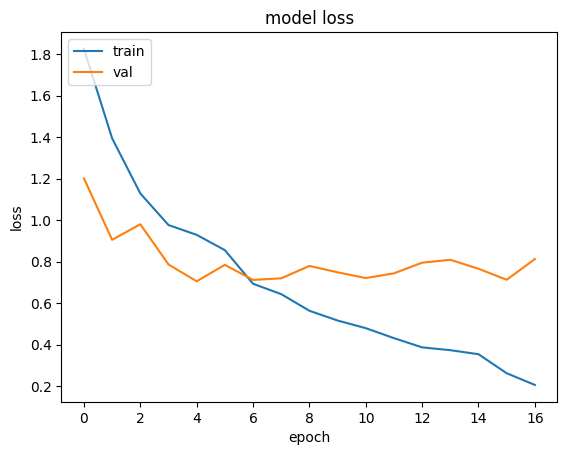

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [23]:
from sklearn.metrics import confusion_matrix, accuracy_score

y_test = test_set.labels # set y_test to the expected output
print(classification_report(y_test, pred2))
print("Accuracy of the Model:","{:.1f}%".format(accuracy_score(y_test, pred2)*100))

              precision    recall  f1-score   support

     Healthy       0.92      0.55      0.69        40
  Osteopenia       0.61      0.85      0.71        33
Osteoporosis       0.50      0.56      0.53        25

    accuracy                           0.65        98
   macro avg       0.68      0.65      0.64        98
weighted avg       0.71      0.65      0.65        98

Accuracy of the Model: 65.3%


In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define the class labels
class_labels = ['Healthy', 'Osteopenia','Osteoporosis']

# Calculate the confusion matrix
cm = confusion_matrix(y_test, pred2)

# Create a figure and plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues')

# Set tick labels and axis labels
plt.xticks(ticks=[0.5, 1.5, 2.5], labels=class_labels)
plt.yticks(ticks=[0.5, 1.5, 2.5], labels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")

# Set the title
plt.title("Confusion Matrix")

# Show the plot
plt.show()


ModuleNotFoundError: No module named 'seaborn'